# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 47.4 MB/s eta 0:00:00


In [ ]:
! pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 6.3 MB/s eta 0:00:00


In [ ]:
! pip install -q transformers

In [ ]:
! pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
import pytorch_lightning as pl

import PIL
from PIL import Image
import os

from transformers import MarianMTModel, MarianTokenizer

from transformers import MT5ForConditionalGeneration, MT5Tokenizer
from transformers import GPTNeoForCausalLM, GPT2Tokenizer

from transformers import CLIPProcessor, CLIPModel

import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')
import pickle


from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import re

# Device

In [ ]:
! nvidia-smi
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Sun Feb 18 13:22:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# data

In [ ]:
## I first tried to train the model but dataset too large
train_images_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train_images_v1'
train_data_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.data.v1.txt'
train_gold_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.gold.v1.txt'

val_images_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1'
val_data_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial.data.v1.txt'
val_gold_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial.gold.v1.txt'


In [ ]:
test_images_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/test/test_images_resized'

test_en_data_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/test/test.data.v1.1.gold/en.test.data.v1.1.txt'
test_en_gold_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/test/test.data.v1.1.gold/en.test.gold.v1.1.txt'

test_fa_data_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/test/test.data.v1.1.gold/fa.test.data.txt'
test_fa_gold_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/test/test.data.v1.1.gold/fa.test.gold.txt'

test_it_data_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/test/test.data.v1.1.gold/it.test.data.v1.1.txt'
test_it_gold_path = '/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/data/test/test.data.v1.1.gold/it.test.gold.v1.1.txt'

In [ ]:

def read_and_set_data(data_path, gold_path, images_path):
  '''
    returns a dictionary where each key is the tuple target word, context and each value is a dictionary composed by:
      list of all names of candidate images
      gold image name
      list of all images in PIL format
      gold image in PIL format
  '''
  d = dict()
  # read data file
  with open(data_path, 'r', encoding='utf-8') as file:
      data_lines = file.readlines()

      file.close()

  # read gold labels file
  with open(gold_path, 'r', encoding='utf-8') as file:
      lines_gold = file.readlines()

      file.close()

  # populate the dictionary
  for i,line in enumerate(data_lines):
        l = line.strip().split('\t')
        w1 = l[0]
        w2 = l[1]
        list_noun_images = l[2:]
        gold_noun = lines_gold[i].strip()
        list_images = []

        tr = T.Compose([          ###resize of image
            T.Resize((128,128)),
          ])

        for noun in list_noun_images:
          image_path = images_path+'/'+noun
          image = Image.open(image_path)

          img_tr = tr(image)
          list_images.append(img_tr)
          image.close()

        gold_image_path = images_path + '/' + gold_noun
        gold_image = Image.open(gold_image_path)
        tr_g = tr(gold_image)
        d[w1,w2] = {
            'list names images':list_noun_images,
            'gold name image': [gold_noun],
            'list images' : list_images,
            'gold image' : [tr_g]

        }
  return d




In [ ]:
test_en = read_and_set_data(test_en_data_path, test_en_gold_path, test_images_path)
test_en,len(test_en)

({('goal',
   'football goal'): {'list names images': ['image.4418.jpg',
    'image.4416.jpg',
    'image.4417.jpg',
    'image.4413.jpg',
    'image.4412.jpg',
    'image.4415.jpg',
    'image.4419.jpg',
    'image.4414.jpg',
    'image.2166.jpg',
    'image.1150.jpg'], 'gold name image': ['image.2166.jpg'], 'list images': [<PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>], 'gold image': [<PIL.Image.Image image mode=RGB size=128x128>]},
  ('mustard',
   'mustard seed'): {'list names images': ['image.4429.png',
    'image.4422.jpg',
    '

In [ ]:
test_it = read_and_set_data(test_it_data_path, test_it_gold_path, test_images_path)
test_it,len(test_it)

({('gomma',
   'gomma per smacchiare'): {'list names images': ['image.3.jpg',
    'image.7.jpg',
    'image.8.jpg',
    'image.1.jpg',
    'image.9.jpg',
    'image.5.jpg',
    'image.6.jpg',
    'image.4.jpg',
    'image.0.jpg',
    'image.2.jpg'], 'gold name image': ['image.8.jpg'], 'list images': [<PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>], 'gold image': [<PIL.Image.Image image mode=RGB size=128x128>]},
  ('asino',
   'asino gioco di carte'): {'list names images': ['image.18.jpg',
    'image.17.jpg',
    'image.11.jpg',
    'ima

In [ ]:
test_fa = read_and_set_data(test_fa_data_path, test_fa_gold_path, test_images_path)
test_fa,len(test_fa)

({('برنج\u200e',
   'فلز برنج'): {'list names images': ['image.2732.jpg',
    'image.2734.jpg',
    'image.2727.jpg',
    'image.2731.jpg',
    'image.2735.jpg',
    'image.2726.jpg',
    'image.2729.jpg',
    'image.2733.jpg',
    'image.2730.jpg',
    'image.2728.jpg'], 'gold name image': ['image.2731.jpg'], 'list images': [<PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>,
    <PIL.Image.Image image mode=RGB size=128x128>], 'gold image': [<PIL.Image.Image image mode=RGB size=128x128>]},
  ('ملخ',
   'ملخ بادی'): {'list names images': ['image.2743.jpg',
    'image.2741.jpg',
    'image.2

# savings and loadings

## savings

In [ ]:
# test_en_file = open("/content/drive/MyDrive/Colab Notebooks Eren/test_en_dict.pkl","wb")
# pickle.dump(test_en,test_en_file)
# test_en_file.close()

# test_fa_file = open("/content/drive/MyDrive/Colab Notebooks Eren/test_fa_dict.pkl","wb")
# pickle.dump(test_fa,test_fa_file)
# test_fa_file.close()

# test_it_file = open("/content/drive/MyDrive/Colab Notebooks Eren/test_it_dict.pkl","wb")
# pickle.dump(test_it,test_it_file)
# test_it_file.close()


#####   Transformers    #####


# model_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model.pkl","wb")
# pickle.dump(model,model_file)
# model_file.close()

# processor_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/processor.pkl","wb")
# pickle.dump(processor,processor_file)
# processor_file.close()

# model_translation_it_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model_translation_it.pkl","wb")
# pickle.dump(model_translation_it,model_translation_it_file)
# model_translation_it_file.close()

# tokenizer_translation_it_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/tokenizer_translation_it.pkl","wb")
# pickle.dump(tokenizer_translation_it,tokenizer_translation_it_file)
# tokenizer_translation_it_file.close()

# model_translation_fa_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model_translation_fa.pkl","wb")
# pickle.dump(model_translation_fa,model_translation_fa_file)
# model_translation_fa_file.close()

# tokenizer_translation_fa_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/tokenizer_translation_fa.pkl","wb")
# pickle.dump(tokenizer_translation_fa,tokenizer_translation_fa_file)
# tokenizer_translation_fa_file.close()

# model_context_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model_context.pkl","wb")
# pickle.dump(model_context,model_context_file)
# model_context_file.close()

# tokenizer_context_file = open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/tokenizer_context.pkl","wb")
# pickle.dump(tokenizer_context,tokenizer_context_file)
# tokenizer_context_file.close()

## loadings

dataframes

In [ ]:
# for english dataframe
per_test_en=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/test_en_dict.pkl","rb")
test_en =pickle.load(per_test_en)

# for farsi dataframe
per_test_fa=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/test_fa_dict.pkl","rb")
test_fa =pickle.load(per_test_fa)

# for italian dataframe
per_test_it=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/test_it_dict.pkl","rb")
test_it =pickle.load(per_test_it)

len(test_en),len(test_it),len(test_fa)

(463, 305, 200)

transformers and tokenizers

In [ ]:
per_model=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model.pkl","rb")
model =pickle.load(per_model)

per_processor=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/processor.pkl","rb")
processor =pickle.load(per_processor)

per_model_translation_it=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model_translation_it.pkl","rb")
model_translation_it =pickle.load(per_model_translation_it)

# per_tokenizer_translation_it=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/tokenizer_translation_it.pkl","rb")
# tokenizer_translation_it =pickle.load(per_tokenizer_translation_it)

per_model_translation_fa=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model_translation_fa.pkl","rb")
model_translation_fa =pickle.load(per_model_translation_fa)

# per_tokenizer_translation_fa=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/tokenizer_translation_fa.pkl","rb")
# tokenizer_translation_fa =pickle.load(per_tokenizer_translation_fa)

per_model_context=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/model_context.pkl","rb")
model_context =pickle.load(per_model_context)

per_tokenizer_context=open("/content/drive/MyDrive/Colab Notebooks/EAI/1/Hot NLP/Homework 3/savings/tokenizer_context.pkl","rb")
tokenizer_context =pickle.load(per_tokenizer_context)

print('Done !')

Done !


In [ ]:
model.to(device)
model_translation_it.to(device)
model_translation_fa.to(device)
model_context.to(device)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj):

In [ ]:
model_it = 'Helsinki-NLP/opus-mt-it-en'
tokenizer_translation_it = MarianTokenizer.from_pretrained(model_it)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/790k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

In [ ]:
model_fa = "persiannlp/mt5-base-parsinlu-opus-translation_fa_en"
tokenizer_translation_fa = MT5Tokenizer.from_pretrained(model_fa)

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_dict):
        '''
          from the data dictionary in input it returns a Dataset where each item is a dictionary containing:
          - words: list of target word and context
          - w1 : target word
          - w2 : contect
          - list candidates names: list containing names of the candidates
          - label name: name of gold image
          - list candidates: list of candidates images in PIL format
          - label: gold image in PIL format
        '''
        self.data_dict = data_dict
        self.data = []
        for elem in data_dict:

          w1_ext = 'this is '+elem[0]
          w2_ext = 'this is '+elem[1]

          words = [elem[0], elem[1]]
          item = {
              'words' : words,
              'w1' : elem[0],
              'w2' : elem[1],
              'list candidates names' : data_dict[elem]['list names images'],
              'label name' : data_dict[elem]['gold name image'],
              'list candidates' : data_dict[elem]['list images'],
              'label' : data_dict[elem]['gold image']
          }

          self.data.append(item)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        return item

In [ ]:
test_en_dataset = MyDataset(test_en)
test_fa_dataset = MyDataset(test_fa)
test_it_dataset = MyDataset(test_it)

some examples

In [ ]:
test_en_dataset.__getitem__(2)

{'words': ['seat', 'eating seat'],
 'w1': 'seat',
 'w2': 'eating seat',
 'list candidates names': ['image.4435.jpg',
  'image.4436.jpg',
  'image.1166.jpg',
  'image.4430.jpg',
  'image.4433.jpg',
  'image.4432.jpg',
  'image.4438.jpg',
  'image.4434.jpg',
  'image.4431.jpg',
  'image.4437.jpg'],
 'label name': ['image.4432.jpg'],
 'list candidates': [<PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>],
 'label': [<PIL.Image.Image image mode=RGB size=128x128>]}

In [ ]:
test_fa_dataset.__getitem__(5)

{'words': ['پیوند', 'پیوند شاخه'],
 'w1': 'پیوند',
 'w2': 'پیوند شاخه',
 'list candidates names': ['image.2776.jpg',
  'image.2779.jpg',
  'image.2781.jpg',
  'image.2778.png',
  'image.2774.jpg',
  'image.2777.jpg',
  'image.2773.png',
  'image.2775.jpg',
  'image.2782.png',
  'image.2780.jpg'],
 'label name': ['image.2774.jpg'],
 'list candidates': [<PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGBA size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=P size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGBA size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>],
 'label': [<PIL.Image.Image image mode=RGB size=128x128>]}

In [ ]:
test_it_dataset.__getitem__(17)

{'words': ['iceberg', 'iceberg di ghiaccio'],
 'w1': 'iceberg',
 'w2': 'iceberg di ghiaccio',
 'list candidates names': ['image.178.jpg',
  'image.175.jpg',
  'image.179.jpg',
  'image.172.jpg',
  'image.176.jpg',
  'image.177.jpg',
  'image.173.jpg',
  'image.174.jpg',
  'image.170.jpg',
  'image.171.jpg'],
 'label name': ['image.177.jpg'],
 'list candidates': [<PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>],
 'label': [<PIL.Image.Image image mode=RGB size=128x128>]}

# Clip
# Idea:

*   Use Clip to get the embeddings of the candidate images, target word and its context
*   get the similarity of each candidate image - word/context
*   take the mean of the the similarities of the image[i] with the word and its context
*   the image with the highest mean similarity is the predicted one



In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

## English

In [ ]:
# Processa il testo e le immagini
tot_en = test_en_dataset.__len__()
correct_en = 0


for i in range(test_en_dataset.__len__()):
  item = test_en_dataset.__getitem__(i)
  texts = item['words']
  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarity

  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  # mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  # highest similarity
  highest_similarity_index = mean_similarities.argmax().item()



  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_en += 1
  else:
    print('NOT CORRECT\n')



correct

NOT CORRECT

correct

NOT CORRECT

correct

correct

correct

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

correct

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

correct

correct

correct

correct

NOT CORRECT

correct

correct

correct

correct

correct

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

correct

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

correct

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

correct

correct

correct

correct

NOT CORRECT

NOT CORRECT

correct

correct

NOT CORRECT

NOT CORRECT

correct

correct

cor

In [ ]:
acc_en = correct_en/tot_en
acc_en

0.5053995680345572

## Italian

In [ ]:
tot_it = test_it_dataset.__len__()
correct_it = 0


for i in range(test_it_dataset.__len__()):
  item = test_it_dataset.__getitem__(i)
  texts = item['words']
  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities

  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  # mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_it += 1
  else:
    print('NOT CORRECT\n')


NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

correct

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

correct

NOT CORRECT

correct

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

correct

NOT CORRECT

NO

In [ ]:
acc_it = correct_it/tot_it
acc_it

0.18360655737704917

## Farsi

In [ ]:

tot_fa = test_fa_dataset.__len__()
correct_fa = 0


for i in range(test_fa_dataset.__len__()):
  item = test_fa_dataset.__getitem__(i)
  texts = item['words']
  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities

  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  # mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_fa += 1
  else:
    print('NOT CORRECT\n')


NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

NOT CORRECT

correct

NOT CO

In [ ]:
acc_fa = correct_fa/tot_fa
acc_fa

0.07

## total accuracy

In [ ]:
correct_tot = correct_en + correct_it + correct_fa
tot_tot = tot_en + tot_it + tot_fa
acc_tot = correct_tot/tot_tot
acc_tot

0.3140495867768595

In [ ]:
acc_en = correct_en/tot_en
acc_it = correct_it/tot_it
acc_fa = correct_fa/tot_fa
acc_en, acc_it, acc_fa

(0.5053995680345572, 0.18360655737704917, 0.07)

# Translation
# Idea:


*   Translate every word and its context from Italian/Farsi to English
*   Do the same as in 'Clip' section



## Italian - English

In [ ]:
model_it = 'Helsinki-NLP/opus-mt-it-en'

# Carica tokenizer e modello
tokenizer_translation_it = MarianTokenizer.from_pretrained(model_it)
model_translation_it = MarianMTModel.from_pretrained(model_it)
model_translation_it.to(device)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/790k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/344M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(80379, 512, padding_idx=80378)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(80379, 512, padding_idx=80378)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

example

In [ ]:

text_italian_list = ['chiocciola', 'chiocciola strisciante']


tokenized_texts = tokenizer_translation_it(text_italian_list, return_tensors="pt", padding=True, truncation=True).to(device)

translated_tokens = model_translation_it.generate(**tokenized_texts,no_repeat_ngram_size=2)

# move to cpu for decoding
translated_tokens = translated_tokens.cpu()

# decode
text_english_list = [tokenizer_translation_it.decode(t, skip_special_tokens=True) for t in translated_tokens]

for t in text_english_list:
  print(t)

snail
crawling snail


In [ ]:

tot_it = test_it_dataset.__len__()
correct_it = 0


for i in range(test_it_dataset.__len__()):
  item = test_it_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_it(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_it.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato


  translated_tokens = translated_tokens.cpu()


  translated_text = [tokenizer_translation_it.decode(t, skip_special_tokens=True) for t in translated_tokens]

  print(texts,translated_text)

  ##################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=translated_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  # mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_it += 1
  else:
    print('NOT CORRECT\n')



['gomma', 'gomma per smacchiare'] ['rubber', 'rubber for detaching']
NOT CORRECT

['asino', 'asino gioco di carte'] ['donkey', 'Ass card game']
NOT CORRECT

['colonna', 'colonna missione'] ['column', 'mission column']
NOT CORRECT

['box', 'box per infanti'] ['box', 'infant box']
NOT CORRECT

['bolla', 'bolla di misurazione'] ['bubble', 'measuring bubble']
NOT CORRECT

['banco', 'banco scrivania'] ['bench', 'desk desk']
NOT CORRECT

['durone', 'durone arbusto'] ['durone', 'Duron shrub']
NOT CORRECT

['alfiere', 'alfiere si muove in diagonale'] ['bishop', 'bishop moves diagonally']
correct

['chiocciola', 'chiocciola strisciante'] ['snail', 'crawling snail']
correct

['aquila', 'aquila stelle'] ['eagle', 'eagle stars']
NOT CORRECT

['esecuzione', 'esecuzione esibizione'] ['execution', 'performing performance']
NOT CORRECT

['medusa', "medusa d'acqua"] ['jellyfish', 'water jellyfish']
correct

['cassa', 'cassa da fuoco'] ['cash', 'Firebox']
NOT CORRECT

['bacino', 'bacino lago'] ['pelvis'

In [ ]:
acc_it = correct_it/tot_it
acc_it

0.42950819672131146

## Farsi - English

In [ ]:

model_fa = "persiannlp/mt5-base-parsinlu-opus-translation_fa_en"
tokenizer_translation_fa = MT5Tokenizer.from_pretrained(model_fa)
model_translation_fa = MT5ForConditionalGeneration.from_pretrained(model_fa)

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [ ]:
model_translation_fa.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

example

In [ ]:
text_fa_list = ["وی از تمامی بلاگرها، سازمان‌ها و افرادی که از وی پشتیبانی کرده‌اند، تشکر کرد."]

tokenized_texts = tokenizer_translation_fa(text_fa_list, return_tensors="pt", padding=True, truncation=True).to(device)

# translation
translated_tokens = model_translation_fa.generate(**tokenized_texts,no_repeat_ngram_size=2)

# move to cpu for decoding
translated_tokens = translated_tokens.cpu()

# decoding
text_english_list = [tokenizer_translation_fa.decode(t, skip_special_tokens=True) for t in translated_tokens]

print(text_english_list)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['She thanked all the bloggers, organizations, and men who had supported her.']


In [ ]:

tot_fa = test_fa_dataset.__len__()
correct_fa = 0


for i in range(test_fa_dataset.__len__()):
  item = test_fa_dataset.__getitem__(i)
  texts = item['words']

  ###   translation   ####

  tokenized_texts = tokenizer_translation_fa(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_fa.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato

  # move to cpu for decoding
  translated_tokens = translated_tokens.cpu()

  # decoding
  translated_text = [tokenizer_translation_fa.decode(t, skip_special_tokens=True) for t in translated_tokens]

  print(texts,translated_text)

  #################################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=translated_text, images=images, return_tensors="pt", padding=True).to(device)

  # clip model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)
  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_fa += 1
  else:
    print('NOT CORRECT\n')



['برنج\u200e', 'فلز برنج'] ['rice', 'rice metal']
NOT CORRECT

['ملخ', 'ملخ بادی'] ['- Meal.', 'A wind swallow.']
correct

['شام', 'سرزمین شام'] ['Dinner', 'Dinner country']
NOT CORRECT

['عدسی', 'عدسی نور'] ['Adios.', 'A lens of light.']
correct

['توپ', 'توپ نظامی'] ['A cannon.', 'Military cannon']
correct

['پیوند', 'پیوند شاخه'] ['Conversion', 'branch junction']
NOT CORRECT

['دسته', 'دسته لیوان'] ['Working group', 'glasses.']
NOT CORRECT

['چنگ', 'چنگ پلنگ'] ['Chin.', 'claw.']
NOT CORRECT

['سرطان', 'سرطان برج جوزا'] ['Cancer.', 'Cancer in the tower of Gracia.']
correct

['عاج', 'عاج فیل'] ['- Urgh.', '- Ivory.']
NOT CORRECT

['گیلاس', 'جام گیلاس'] ['A glass.', 'glass of glass']
correct

['جدول', 'جدول اعداد'] ['Table', 'Preparation table']
NOT CORRECT

['رکاب', 'رکاب زین'] ['Rough.', 'saddle riding']
NOT CORRECT

['کبک', 'استان کبک'] ["'Kabbott.", 'county of buck']
NOT CORRECT

['زبان', 'زبان سرخ'] ['Language', 'Red tongue.']
correct

['پرچم', 'پرچم نر'] ['The flag', 'The flag of

In [ ]:
acc_fa = correct_fa/tot_fa
acc_fa

0.305

## total accuracy

In [ ]:
correct_tot = correct_en + correct_it + correct_fa
tot_tot = tot_en + tot_it + tot_fa
acc_tot = correct_tot/tot_tot
acc_tot

0.44008264462809915

In [ ]:
acc_en = correct_en/tot_en
acc_it = correct_it/tot_it
acc_fa = correct_fa/tot_fa
acc_en, acc_it, acc_fa

(0.5053995680345572, 0.42950819672131146, 0.305)

# GPT Context
# Idea:
(After translating if necessary) Add a sentence with major context for the target word


*  use gpt to generate a descriptive sentence about the target word context
*  clean the generated sentence (take off the used prompt and other special characters)
*  do as in Clip section


In [ ]:
model_context = "EleutherAI/gpt-neo-1.3B"
tokenizer_context = GPT2Tokenizer.from_pretrained(model_context)
model_context = GPTNeoForCausalLM.from_pretrained(model_context)
tokenizer_context.add_special_tokens({'pad_token': '[PAD]'})
model_context.to(device)

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj):

example

In [ ]:
# descriptive prompt
input_text = "Write a descriptive sentence about '"+test_en_dataset.__getitem__(5)['w2']+"':"

# encoding
encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)


# generation of the model
output = model_context.generate(
    input_ids = input_ids,
    attention_mask = attention_mask,
    pad_token_id = 50256 , #eos_token_id
    max_length=50,
    num_return_sequences=1,
    temperature=0.7, # news of the text??
    top_k=50, ## 50 most probable tokens
).to(device)

# decode
generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

# remove the prompt
generated_text_cleaned = generated_text.replace(input_text, '').strip().split('.')[0]

print(test_en_dataset.__getitem__(5)['w2'],'\n',generated_text_cleaned)

neptune statue 
 The Neptune statue is a sculpture of Neptune, the Roman god of the sea, located in the port of Naples, Italy


## English

In [ ]:
test_en_dataset.__getitem__(5)

{'words': ['neptune', 'neptune statue'],
 'w1': 'neptune',
 'w2': 'neptune statue',
 'list candidates names': ['image.4459.jpg',
  'image.4461.jpg',
  'image.4456.jpg',
  'image.4462.jpg',
  'image.4460.jpg',
  'image.4457.jpg',
  'image.4464.jpg',
  'image.4458.jpg',
  'image.4465.jpg',
  'image.4463.jpg'],
 'label name': ['image.4464.jpg'],
 'list candidates': [<PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=L size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>,
  <PIL.Image.Image image mode=RGB size=128x128>],
 'label': [<PIL.Image.Image image mode=RGB size=128x128>]}

In [ ]:
test_en_dataset.__getitem__(5)['w2']

'neptune statue'

In [ ]:
tot_en = test_en_dataset.__len__()
correct_en = 0


for i in range(test_en_dataset.__len__()):
  item = test_en_dataset.__getitem__(i)
  texts = item['words']
  images = item['list candidates']
  gold = item['label'][0]


  #####     gpt       #######
  # prompt
  input_text = "Write a descriptive sentence about'"+item['w2']+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      temperature=0.7, # news of the text??
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # remove the prompt from the generated sentence and clean the text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]



  in_text = texts.copy()
  in_text.append(generated_text_cleaned)
  print(in_text)
  ############################################

  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities

  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_en += 1
  else:
    print('NOT CORRECT\n')


['goal', 'football goal', 'The goal is scored by a player who is in possession of the ball']
correct

['mustard', 'mustard seed', 'The makings of a good mince pie are:']
NOT CORRECT

['seat', 'eating seat', 'I ate a seat']
correct

['navigate', 'navigate the web', 'Navigate the web is a process of moving from one web page to another']
correct

['butterball', 'butterball person', 'The butterball person is a person who is very intelligent, but also very shy']
correct

['neptune', 'neptune statue', 'The statue of Neptune is a famous symbol of the ancient world']
correct

['tympanum', 'ear tympanum', 'The ear tympanum is a small opening in the middle of the ear']
correct

['thymus', 'wild thymus', 'Wild thymus is a plant that grows in the mountains of the Himalayas']
NOT CORRECT

['tender', 'tender embrace', "Tender embrace is a term used to describe a person's emotional response to another person's physical contact"]
NOT CORRECT

['mill', 'mill grinding', "I'm grinding my teeth to grind m

In [ ]:
acc_en = correct_en/tot_en
acc_en

0.5701943844492441

## Italian

In [ ]:
tot_it = test_it_dataset.__len__()
correct_it = 0


for i in range(test_it_dataset.__len__()):
  item = test_it_dataset.__getitem__(i)
  texts = item['words']

  ### Translation ###

  tokenized_texts = tokenizer_translation_it(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_it.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato


  translated_tokens = translated_tokens.cpu()


  translated_text = [tokenizer_translation_it.decode(t, skip_special_tokens=True) for t in translated_tokens]

  ##################

  #### gpt  #####

  # prompt
  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=75,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # remove the prompt from the generated sentence and clean the text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]

  in_text = translated_text.copy()
  in_text.append(generated_text_cleaned)
  print(in_text)

  ######################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()


  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_it += 1
  else:
    print('NOT CORRECT\n')



['rubber', 'rubber for detaching', 'Rubber for detaching is a material that is used to attach a device to a surface']
NOT CORRECT

['donkey', 'Ass card game', 'Ass card game is a card game that is played in the United States']
NOT CORRECT

['column', 'mission column', 'The mission column is a column that is used to describe the mission of the organization']
NOT CORRECT

['box', 'infant box', 'The infant box is a small, rectangular box that is used to hold an infant']
correct

['bubble', 'measuring bubble', 'The bubble is a small, round, white, plastic object that is used to measure the volume of a liquid']
NOT CORRECT

['bench', 'desk desk', "'The desk is a desk':"]
NOT CORRECT

['durone', 'Duron shrub', 'Duron shrub is a shrub that grows in the mountains of the western United States']
NOT CORRECT

['bishop', 'bishop moves diagonally', 'The bishop moves diagonally']
correct

['snail', 'crawling snail', 'The snail crawled up the wall and then crawled back down again']
correct

['eagle',

In [ ]:
acc_it = correct_it/tot_it
acc_it

0.4459016393442623

## Farsi

In [ ]:

tot_fa = test_fa_dataset.__len__()
correct_fa = 0


for i in range(test_fa_dataset.__len__()):
  item = test_fa_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_fa(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}

  translated_tokens = model_translation_fa.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato
  # move to cpu for decoding
  translated_tokens = translated_tokens.cpu()

  # decoding
  translated_text = [tokenizer_translation_fa.decode(t, skip_special_tokens=True) for t in translated_tokens]

  ######################################

  ### gpt ###

  # prompt
  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean the generated_text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]


  in_text = translated_text.copy()
  in_text.append(generated_text_cleaned)
  print(in_text)
  ######################################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)

  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_fa += 1
  else:
    print('NOT CORRECT\n')


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['rice', 'rice metal', 'Rice metal is a type of metal that is made from rice']
NOT CORRECT

['- Meal.', 'A wind swallow.', 'A wind swallow is a small bird in the family Hirundinidae']
correct

['Dinner', 'Dinner country', 'Dinner country is a country in the United States']
NOT CORRECT

['Adios.', 'A lens of light.', 'A lens of light']
correct

['A cannon.', 'Military cannon', 'The military cannon is a type of cannon that is used in the military']
correct

['Conversion', 'branch junction', 'The branch junction is a junction between two branches of a tree']
NOT CORRECT

['Working group', 'glasses.', 'The glasses are a type of glass']
NOT CORRECT

['Chin.', 'claw.', 'The claw is a small, claw-like appendage on the end of the tail of a fish']
NOT CORRECT

['Cancer.', 'Cancer in the tower of Gracia.', 'Cancer in the tower of Gracia']
correct

['- Urgh.', '- Ivory.', 'Ivory is a very beautiful and rare bird']
correct

['A glass.', 'glass of glass', 'Glass of glass is a type of glass that is 

In [ ]:
acc_fa = correct_fa/tot_fa
acc_fa

0.33

## total accuracy

In [ ]:
correct_tot = correct_en + correct_it + correct_fa
tot_tot = tot_en + tot_it + tot_fa
acc_tot = correct_tot/tot_tot
acc_tot

0.4762396694214876

In [ ]:
acc_en = correct_en/tot_en
acc_it = correct_it/tot_it
acc_fa = correct_fa/tot_fa
acc_en, acc_it, acc_fa

(0.5701943844492441, 0.4459016393442623, 0.33)

# wordnet
# Idea:
Add context with the right synset


*   take all the synsets of the target word
*   choose the synset where the context of the word appears in its definition
*   the definition of the chosen synset is added to the list of the sentences to be used with the Clip model





example

In [ ]:
word = 'bank'
context = 'financial institution'

synsets = wn.synsets(word)

synset_corretto = None
for synset in synsets:
    if context in synset.definition():
        synset_corretto = synset
        break

if synset_corretto:
    print("Synset found:", synset_corretto, synset_corretto.definition())
else:
    print("No sysnset! :(")

Synset found: Synset('depository_financial_institution.n.01') a financial institution that accepts deposits and channels the money into lending activities


## English

example

In [ ]:
for i in range(10):
  elem = test_en_dataset.__getitem__(i)

  word = elem['w1']
  c_words = elem['w2'].split()
  for c_w in c_words:     ### in the dataset the context is context + target_word, therefore I exclude the target_word
    if c_w != word:
      context = c_w


  synsets = wn.synsets(word)

  # finding the right sysnset
  synset_corretto = None
  for synset in synsets:
      if context in synset.definition():
          synset_corretto = synset
          break
  print(word,context)
  if synset_corretto:
      print("Synset found:", synset_corretto, synset_corretto.definition())
      sy = elem['w2'] +' is '+ synset_corretto.definition()# sy = str(synset_corretto.definition())
      print(sy,'\n')
  else:
      print("No sysnset! :(",'\n')


goal football
No sysnset! :( 

mustard seed
Synset found: Synset('mustard.n.02') pungent powder or paste prepared from ground mustard seeds
mustard seed is pungent powder or paste prepared from ground mustard seeds 

seat eating
No sysnset! :( 

navigate web
No sysnset! :( 

butterball person
No sysnset! :( 

neptune statue
No sysnset! :( 

tympanum ear
Synset found: Synset('middle_ear.n.01') the main cavity of the ear; between the eardrum and the inner ear
ear tympanum is the main cavity of the ear; between the eardrum and the inner ear 

thymus wild
No sysnset! :( 

tender embrace
No sysnset! :( 

mill grinding
Synset found: Synset('mill.n.04') machinery that processes materials by grinding or crushing
mill grinding is machinery that processes materials by grinding or crushing 



In [ ]:
tot_en = test_en_dataset.__len__()
correct_en = 0


for i in range(test_en_dataset.__len__()):
  item = test_en_dataset.__getitem__(i)
  texts = item['words']


  ##### wordnet #####
  word = item['w1']
  c_words = item['w2'].split()
  for c_w in c_words:     ### in the dataset the context is context + target_word, therefore I exclude the target_word
    if c_w != word:
      context = c_w

  synsets = wn.synsets(word)

  in_text = texts.copy()

  synset_corretto = None
  for synset in synsets:
      if context in synset.definition():
          synset_corretto = synset
          break

  if synset_corretto:
      sy = item['w2'] +' is '+ synset_corretto.definition()# sy = str(synset_corretto.definition())
      in_text.append(sy)


  # else:
  #### gpt context ####
  # prompt
  input_text = "Write a descriptive sentence about'"+item['w2']+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean the generated text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]

  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)

  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)


  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_en += 1
  else:
    print('NOT CORRECT\n')


['football goal', 'The goal is scored by a player who is in possession of the ball']
correct

['mustard seed', 'mustard seed is pungent powder or paste prepared from ground mustard seeds', 'The makings of a good mince pie are:']
correct

['eating seat', 'I ate a seat']
correct

['navigate the web', 'Navigate the web is a process of moving from one web page to another']
correct

['butterball person', 'The butterball person is a person who is very intelligent, but also very shy']
correct

['neptune statue', 'The statue of Neptune is a famous symbol of the ancient world']
correct

['ear tympanum', 'ear tympanum is the main cavity of the ear; between the eardrum and the inner ear', 'The ear tympanum is a small opening in the middle of the ear']
NOT CORRECT

['wild thymus', 'Wild thymus is a plant that grows in the mountains of the Himalayas']
correct

['tender embrace', "Tender embrace is a term used to describe a person's emotional response to another person's physical contact"]
NOT CORRE

In [ ]:
acc_en = correct_en/tot_en
acc_en,tot_en

(0.6306695464362851, 463)

## Italian

In [ ]:

tot_it = test_it_dataset.__len__()
correct_it = 0


for i in range(test_it_dataset.__len__()):
  item = test_it_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_it(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_it.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato

  translated_tokens = translated_tokens.cpu()

  translated_text = [tokenizer_translation_it.decode(t, skip_special_tokens=True) for t in translated_tokens]

  ##################

  ###########  add context   ########
  in_text = translated_text.copy()

  ####    wordnet       ######
  ##### wordnet #####
  word = translated_text[0]
  c_words = translated_text[1].split()
  for c_w in c_words:
    if c_w != word:
      context = c_w

  synsets = wn.synsets(word)

  synset_corretto = None
  for synset in synsets:
      if context in synset.definition():
          synset_corretto = synset
          break

  if synset_corretto:
      sy = translated_text[1] +' is '+ synset_corretto.definition()# sy = str(synset_corretto.definition())
      in_text.append(sy)

  # else:
      ####   gpt   #####

  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=75,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean the generated text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]


  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)


  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_it += 1
  else:
    print('NOT CORRECT\n')



['rubber for detaching', 'Rubber for detaching is a material that is used to attach a device to a surface']
NOT CORRECT

['Ass card game', 'Ass card game is a card game that is played in the United States']
correct

['mission column', 'The mission column is a column that is used to describe the mission of the organization']
NOT CORRECT

['infant box', 'The infant box is a small, rectangular box that is used to hold an infant']
correct

['measuring bubble', 'The bubble is a small, round, white, plastic object that is used to measure the volume of a liquid']
NOT CORRECT

['desk desk', "'The desk is a desk':"]
correct

['Duron shrub', 'Duron shrub is a shrub that grows in the mountains of the western United States']
NOT CORRECT

['bishop moves diagonally', 'bishop moves diagonally is (chess) a piece that can be moved diagonally over unoccupied squares of the same color', 'The bishop moves diagonally']
NOT CORRECT

['crawling snail', 'The snail crawled up the wall and then crawled back dow

In [ ]:
acc_it = correct_it/tot_it
acc_it

0.49508196721311476

## Farsi

In [ ]:
# Processa il testo e le immagini
tot_fa = test_fa_dataset.__len__()
correct_fa = 0


for i in range(test_fa_dataset.__len__()):
  item = test_fa_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_fa(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}

  translated_tokens = model_translation_fa.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato
  # move to cpu for decoding
  translated_tokens = translated_tokens.cpu()

  # decoding
  translated_text = [tokenizer_translation_fa.decode(t, skip_special_tokens=True) for t in translated_tokens]

  ######################################

  ########### add context       ########
  in_text = translated_text.copy()

  ####    wordnet       ######
  ##### wordnet #####
  word = translated_text[0]
  c_words = translated_text[1].split()
  for c_w in c_words:
    if c_w != word:
      context = c_w

  synsets = wn.synsets(word)

  synset_corretto = None
  for synset in synsets:
      if context in synset.definition():
          synset_corretto = synset
          break

  if synset_corretto:
      sy = translated_text[1] +' is '+ synset_corretto.definition()
      in_text.append(sy)

  # else:       ####   gpt   #####

  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decodiing
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean the text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]

  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)
  #####################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_fa += 1
  else:
    print('NOT CORRECT\n')



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['rice metal', 'Rice metal is a type of metal that is made from rice']
NOT CORRECT

['A wind swallow.', 'A wind swallow is a small bird in the family Hirundinidae']
correct

['Dinner country', 'Dinner country is a country in the United States']
NOT CORRECT

['A lens of light.', 'A lens of light']
correct

['Military cannon', 'The military cannon is a type of cannon that is used in the military']
correct

['branch junction', 'The branch junction is a junction between two branches of a tree']
correct

['glasses.', 'The glasses are a type of glass']
NOT CORRECT

['claw.', 'The claw is a small, claw-like appendage on the end of the tail of a fish']
NOT CORRECT

['Cancer in the tower of Gracia.', 'Cancer in the tower of Gracia']
NOT CORRECT

['- Ivory.', 'Ivory is a very beautiful and rare bird']
correct

['glass of glass', 'Glass of glass is a type of glass that is made from a mixture of silica and alumina']
correct

['Preparation table', 'Preparation table is a piece of furniture with tab

In [ ]:
acc_fa = correct_fa/tot_fa
acc_fa

0.325

## total accuracy

In [ ]:
correct_tot = correct_en + correct_it + correct_fa
tot_tot = tot_en + tot_it + tot_fa
acc_tot = correct_tot/tot_tot
acc_tot

0.5247933884297521

In [ ]:
acc_en = correct_en/tot_en
acc_it = correct_it/tot_it
acc_fa = correct_fa/tot_fa
acc_en, acc_it, acc_fa

(0.6306695464362851, 0.49508196721311476, 0.325)

# Wordnet + Lesk
# Idea:
* choose the best synset with the Lesk algorithm
* same as Wordnet section

In [ ]:
from nltk.wsd import lesk

example

In [ ]:

for i in range(10):
  item = test_en_dataset.__getitem__(i)
  word = item['w1']

  context = item['w2']

  # lesk
  synset = lesk(context.split(), word)
  print(word,context)
  if synset:
    print(f"Synset found: {synset}")
    print(f"Definition: {synset.definition()}")
  else:
    print("No synset found :(")

  print('\n\n')


goal football goal
Synset found: Synset('goal.n.04')
Definition: a successful attempt at scoring



mustard mustard seed
Synset found: Synset('mustard.n.02')
Definition: pungent powder or paste prepared from ground mustard seeds



seat eating seat
Synset found: Synset('seat.v.07')
Definition: place in or on a seat



navigate navigate the web
Synset found: Synset('navigate.v.02')
Definition: act as the navigator in a car, plane, or vessel and plan, direct, plot the path and position of the conveyance



butterball butterball person
Synset found: Synset('fatso.n.01')
Definition: a rotund individual



neptune neptune statue
Synset found: Synset('neptune.n.02')
Definition: a giant planet with a ring of ice particles; the 8th planet from the sun is the most remote of the gas giants



tympanum ear tympanum
Synset found: Synset('middle_ear.n.01')
Definition: the main cavity of the ear; between the eardrum and the inner ear



thymus wild thymus
Synset found: Synset('thymus_gland.n.01')
De

## English

In [ ]:

tot_en = test_en_dataset.__len__()
correct_en = 0


for i in range(test_en_dataset.__len__()):
  item = test_en_dataset.__getitem__(i)
  texts = item['words']


  ##### wordnet #####


  in_text = texts.copy()
  synset_corretto = None
  parola = item['w1']

  contesto = item['w2']

  # lesk algorithm
  synset = lesk(contesto.split(), parola)

  if synset:
      sy = contesto+' is '+synset.definition()
      in_text.append(sy)


  # else:
  #### gpt context ####
  # prompt
  input_text = "Write a descriptive sentence about'"+item['w2']+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean generated text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]

  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)
  ##################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)

  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)
  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_en += 1
  else:
    print('NOT CORRECT\n')


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['football goal', 'football goal is a successful attempt at scoring', 'The goal is scored by a player who is in possession of the ball']
correct

['mustard seed', 'mustard seed is pungent powder or paste prepared from ground mustard seeds', 'The makings of a good mince pie are:']
correct

['eating seat', 'eating seat is place in or on a seat', 'I ate a seat']
correct

['navigate the web', 'navigate the web is act as the navigator in a car, plane, or vessel and plan, direct, plot the path and position of the conveyance', 'Navigate the web is a process of moving from one web page to another']
correct

['butterball person', 'butterball person is a rotund individual', 'The butterball person is a person who is very intelligent, but also very shy']
correct

['neptune statue', 'neptune statue is a giant planet with a ring of ice particles; the 8th planet from the sun is the most remote of the gas giants', 'The statue of Neptune is a famous symbol of the ancient world']
correct

['ear tympanum

In [ ]:
acc_en = correct_en/tot_en
acc_en

0.6328293736501079

## Italian

In [ ]:
# Processa il testo e le immagini
tot_it = test_it_dataset.__len__()
correct_it = 0


for i in range(test_it_dataset.__len__()):
  item = test_it_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_it(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_it.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato

  translated_tokens = translated_tokens.cpu()

  translated_text = [tokenizer_translation_it.decode(t, skip_special_tokens=True) for t in translated_tokens]

  ##################

  ###########  add context   ########
  in_text = translated_text.copy()


  ##### wordnet #####

  synset_corretto = None
  parola = translated_text[0]

  contesto = translated_text[1]

  # lesk algorithm
  synset = lesk(contesto.split(), parola)

  if synset:
      sy = contesto+' is '+synset.definition()
      in_text.append(sy)

  # else:       ####   gpt   #####

  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=75,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean the generated text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]


  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)


  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_it += 1
  else:
    print('NOT CORRECT\n')



['rubber for detaching', 'rubber for detaching is coat or impregnate with rubber', 'Rubber for detaching is a material that is used to attach a device to a surface']
NOT CORRECT

['Ass card game', 'Ass card game is the symbol of the Democratic Party; introduced in cartoons by Thomas Nast in 1874', 'Ass card game is a card game that is played in the United States']
correct

['mission column', 'mission column is anything that approximates the shape of a column or tower', 'The mission column is a column that is used to describe the mission of the organization']
NOT CORRECT

['infant box', 'infant box is put into a box', 'The infant box is a small, rectangular box that is used to hold an infant']
correct

['measuring bubble', 'measuring bubble is flow in an irregular current with a bubbling noise', 'The bubble is a small, round, white, plastic object that is used to measure the volume of a liquid']
NOT CORRECT

['desk desk', 'desk desk is a strong worktable for a carpenter or mechanic', "'

In [ ]:
acc_it = correct_it/tot_it
acc_it

0.49508196721311476

## Farsi

In [ ]:
# Processa il testo e le immagini
tot_fa = test_fa_dataset.__len__()
correct_fa = 0


for i in range(test_fa_dataset.__len__()):
  item = test_fa_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_fa(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}

  translated_tokens = model_translation_fa.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato
  # move to cpu for decoding
  translated_tokens = translated_tokens.cpu()

  # decoding
  translated_text = [tokenizer_translation_fa.decode(t, skip_special_tokens=True) for t in translated_tokens]



  ######################################

  ########### add context       ########
  in_text = translated_text.copy()

  ####    wordnet       ######
  ##### wordnet #####

  synset_corretto = None
  parola = translated_text[0]

  contesto = translated_text[1]

  # lesk algorithm
  synset = lesk(contesto.split(), parola)

  if synset:
      sy = contesto+' is '+synset.definition()
      in_text.append(sy)

  # else:       ####   gpt   #####

  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # encoding
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decodiing
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean the text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]

  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)
  #####################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_fa += 1
  else:
    print('NOT CORRECT\n')



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['rice metal', 'rice metal is sieve so that it becomes the consistency of rice', 'Rice metal is a type of metal that is made from rice']
NOT CORRECT

['A wind swallow.', 'A wind swallow is a small bird in the family Hirundinidae']
correct

['Dinner country', 'Dinner country is a party of people assembled to have dinner together', 'Dinner country is a country in the United States']
NOT CORRECT

['A lens of light.', 'A lens of light']
correct

['Military cannon', 'The military cannon is a type of cannon that is used in the military']
correct

['branch junction', 'branch junction is the act of changing from one use or function or purpose to another', 'The branch junction is a junction between two branches of a tree']
correct

['glasses.', 'The glasses are a type of glass']
NOT CORRECT

['claw.', 'The claw is a small, claw-like appendage on the end of the tail of a fish']
NOT CORRECT

['Cancer in the tower of Gracia.', 'Cancer in the tower of Gracia']
NOT CORRECT

['- Ivory.', 'Ivory is a 

In [ ]:
acc_fa = correct_fa/tot_fa
acc_fa

0.32

## total accuracy

In [ ]:
correct_tot = correct_en + correct_it + correct_fa
tot_tot = tot_en + tot_it + tot_fa
acc_tot = correct_tot/tot_tot
acc_tot

0.5247933884297521

In [ ]:
acc_en = correct_en/tot_en
acc_it = correct_it/tot_it
acc_fa = correct_fa/tot_fa
acc_en, acc_it, acc_fa

(0.6328293736501079, 0.49508196721311476, 0.32)

# Wordnet + Sentence Embeddings
# Idea:
* use a sentence transformer to get the embeddings of every synset definition of the target word and the context of the target word
* get the similarities of the target word's context with each synset definition
* the synset with the highest similiraty is chosen
* same as in 'Clip' section

In [ ]:

model_sen = SentenceTransformer('all-MiniLM-L6-v2')

model_sen.to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

example

In [ ]:
context = 'Roman empire'
target_word = 'Caesar'


synsets = wn.synsets(target_word)
max_similarity =-1
best_synset = None
for synset in synsets:
  synset_definition = synset.definition()
  embeddings = model_sen.encode([synset_definition, context])

  embeddings_tensor = torch.tensor(embeddings)

  # similarity
  cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


  if cos_sim > max_similarity:
      max_similarity = cos_sim
      best_synset = synset

if best_synset:
    print("Synset selezionato:", best_synset, best_synset.definition())
else:
    print("Nessun synset trovato per la parola target.")

Synset selezionato: Synset('caesar.n.01') conqueror of Gaul and master of Italy (100-44 BC)


## English

In [ ]:
eng_pred = list()
tot_en = test_en_dataset.__len__()
correct_en = 0


for i in range(test_en_dataset.__len__()):
  item = test_en_dataset.__getitem__(i)
  texts = item['words']
  target_word = item['w1']
  in_text = texts.copy()

  ##### Sentence Embeddings #####
  context = item['w2']


  synsets = wn.synsets(target_word)
  max_similarity = -1
  best_synset = None

  for synset in synsets:
      # definition of synset as context
      synset_definition = synset.definition()

      embeddings = model_sen.encode([synset_definition, context])

      embeddings_tensor = torch.tensor(embeddings)

      # similarity
      cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


      if cos_sim > max_similarity:
          max_similarity = cos_sim
          best_synset = synset

  if best_synset:
    sy = item['w2']+' is '+ best_synset.definition()
    in_text.append(sy)


  #### gpt context ####
    # prompt
  input_text = "Write a descriptive sentence about'"+item['w2']+"':"

  # encoding
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decodimg
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean generated text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]

  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)
  ##############################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)
  #  mean of the similarity between the word-image and context-image
  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]

  if predicted_image == gold:
    print('correct\n')
    correct_en += 1
  else:
    print('NOT CORRECT\n')

  # for prediction list in order to write it into the txt file

  images_names = item['list candidates names']
  predicted_image_name = images_names[highest_similarity_index]
  eng_pred.append(predicted_image_name)


['football goal', 'football goal is a successful attempt at scoring', 'The goal is scored by a player who is in possession of the ball']
correct

['mustard seed', 'mustard seed is pungent powder or paste prepared from ground mustard seeds', 'The makings of a good mince pie are:']
correct

['eating seat', 'eating seat is put a seat on a chair', 'I ate a seat']
correct

['navigate the web', 'navigate the web is act as the navigator in a car, plane, or vessel and plan, direct, plot the path and position of the conveyance', 'Navigate the web is a process of moving from one web page to another']
correct

['butterball person', 'butterball person is a rotund individual', 'The butterball person is a person who is very intelligent, but also very shy']
correct

['neptune statue', 'neptune statue is a giant planet with a ring of ice particles; the 8th planet from the sun is the most remote of the gas giants', 'The statue of Neptune is a famous symbol of the ancient world']
correct

['ear tympanum

In [ ]:
acc_en = correct_en/tot_en
acc_en

0.6328293736501079

## Italian

In [ ]:
tot_it = test_it_dataset.__len__()
correct_it = 0
it_pred = list()

for i in range(test_it_dataset.__len__()):
  item = test_it_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_it(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_it.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato

  translated_tokens = translated_tokens.cpu()

  translated_text = [tokenizer_translation_it.decode(t, skip_special_tokens=True) for t in translated_tokens]

  ##################

  ###########  add context   ########

  ########### add context       ########
  in_text = translated_text.copy()

  ##### Sentence Embeddings #####
  target_word = translated_text[0]
  context = translated_text[1]


  synsets = wn.synsets(target_word)
  max_similarity = -1
  best_synset = None

  for synset in synsets:
      # definition of synset as context
      synset_definition = synset.definition()

      embeddings = model_sen.encode([synset_definition, context])

      embeddings_tensor = torch.tensor(embeddings)

      # similarity
      cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


      if cos_sim > max_similarity:
          max_similarity = cos_sim
          best_synset = synset

  if best_synset:
    sy = translated_text[1]+' is '+ best_synset.definition()
    in_text.append(sy)


  # else:       ####   gpt   #####
  # prompt
  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # Tokenizza il testo di input
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)
  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=75,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Decoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean the text
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]


  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)
  ###################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # model clip
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  # similarities
  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)

  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()

  predicted_image = images[highest_similarity_index]


  if predicted_image == gold:
    print('correct\n')
    correct_it += 1
  else:
    print('NOT CORRECT\n')

  # prediction lists to write into the txt file
  images_names = item['list candidates names']
  predicted_image_name = images_names[highest_similarity_index]

  it_pred.append(predicted_image_name)


['rubber for detaching', 'rubber for detaching is an eraser made of rubber (or of a synthetic material with properties similar to rubber); commonly mounted at one end of a pencil', 'Rubber for detaching is a material that is used to attach a device to a surface']
NOT CORRECT

['Ass card game', 'Ass card game is domestic beast of burden descended from the African wild ass; patient but stubborn', 'Ass card game is a card game that is played in the United States']
correct

['mission column', 'mission column is a page or text that is vertically divided', 'The mission column is a column that is used to describe the mission of the organization']
NOT CORRECT

['infant box', 'infant box is put into a box', 'The infant box is a small, rectangular box that is used to hold an infant']
correct

['measuring bubble', 'measuring bubble is rise in bubbles or as if in bubbles', 'The bubble is a small, round, white, plastic object that is used to measure the volume of a liquid']
NOT CORRECT

['desk desk

In [ ]:
acc_it = correct_it/tot_it
acc_it

0.5016393442622951

## Farsi

In [ ]:

tot_fa = test_fa_dataset.__len__()
correct_fa = 0

fa_pred = list()

for i in range(test_fa_dataset.__len__()):
  item = test_fa_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_fa(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  tokenized_texts = {k: v.to(device) for k, v in tokenized_texts.items()}

  translated_tokens = model_translation_fa.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato
  # move to cpu for decoding
  translated_tokens = translated_tokens.cpu()

  # Decodiing
  translated_text = [tokenizer_translation_fa.decode(t, skip_special_tokens=True) for t in translated_tokens]


  ######################################


  ########### add context       ########
  in_text = translated_text.copy()

  ##### Sentence Embeddings #####
  target_word = translated_text[0]
  context = translated_text[1]


  synsets = wn.synsets(target_word)
  max_similarity = -1
  best_synset = None

  for synset in synsets:
      # definition of synset as context
      synset_definition = synset.definition()

      embeddings = model_sen.encode([synset_definition, context])

      embeddings_tensor = torch.tensor(embeddings)

      # similarity
      cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


      if cos_sim > max_similarity:
          max_similarity = cos_sim
          best_synset = synset

  if best_synset:
    sy = translated_text[1]+' is '+ best_synset.definition()
    in_text.append(sy)


  # else:       ####   gpt   #####
  # prompt
  input_text = "Write a descriptive sentence about'"+translated_text[1]+"':"

  # Tokenizza il testo di input
  input_ids = tokenizer_context.encode(input_text, return_tensors="pt").to(device)
  encoded_input = tokenizer_context(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  input_ids = encoded_input['input_ids'].to(device)
  attention_mask = encoded_input['attention_mask'].to(device)

  # generation
  output = model_context.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      pad_token_id = 50256 , #eos_token_id
      max_length=50,
      num_return_sequences=1, #number of generated sentences
      top_k=50, ## 50 most probable tokens
  ).to(device)

  # Ddecoding
  generated_text = tokenizer_context.decode(output[0], skip_special_tokens=True)

  # clean
  generated_text_cleaned = generated_text.replace(input_text, '').replace('"','').strip().split('.')[0].split('\n')[0]


  in_text.append(generated_text_cleaned)

  in_text = in_text[1:]
  print(in_text)
  ################

  images = item['list candidates']
  gold = item['label'][0]
  inputs = processor(text=in_text, images=images, return_tensors="pt", padding=True).to(device)

  # clip
  outputs = model(**inputs)

  # embeddings
  text_features = outputs.text_embeds
  image_features = outputs.image_embeds

  similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)


  mean_similarities = similarities.mean(dim=0)

  highest_similarity_index = mean_similarities.argmax().item()
  predicted_image = images[highest_similarity_index]
  if predicted_image == gold:
    print('correct\n')
    correct_fa += 1
  else:
    print('NOT CORRECT\n')

  # prediction lists to write into the txt file
  images_names = item['list candidates names']
  predicted_image_name = images_names[highest_similarity_index]
  fa_pred.append(predicted_image_name)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['rice metal', 'rice metal is sieve so that it becomes the consistency of rice', 'Rice metal is a type of metal that is made from rice']
NOT CORRECT

['A wind swallow.', 'A wind swallow is a small bird in the family Hirundinidae']
correct

['Dinner country', 'Dinner country is a party of people assembled to have dinner together', 'Dinner country is a country in the United States']
NOT CORRECT

['A lens of light.', 'A lens of light']
correct

['Military cannon', 'The military cannon is a type of cannon that is used in the military']
correct

['branch junction', 'branch junction is act of exchanging one type of money or security for another', 'The branch junction is a junction between two branches of a tree']
NOT CORRECT

['glasses.', 'The glasses are a type of glass']
NOT CORRECT

['claw.', 'The claw is a small, claw-like appendage on the end of the tail of a fish']
NOT CORRECT

['Cancer in the tower of Gracia.', 'Cancer in the tower of Gracia']
NOT CORRECT

['- Ivory.', 'Ivory is a ver

In [ ]:
acc_fa = correct_fa/tot_fa
acc_fa

0.315

## total accuracy

In [ ]:
correct_tot = correct_en + correct_it + correct_fa
tot_tot = tot_en + tot_it + tot_fa
acc_tot = correct_tot/tot_tot
acc_tot

0.5258264462809917

In [ ]:
acc_en = correct_en/tot_en
acc_it = correct_it/tot_it
acc_fa = correct_fa/tot_fa
acc_en, acc_it, acc_fa

(0.6328293736501079, 0.5016393442622951, 0.315)

# Image Captioning

# Idea:

*   use a ViT to obtain a caption for every candidate image
*   use a sentence transformer to get embeddings of each caption and the context of the target word
*   get the similarity of each caption with the context
*   the image whose caption gets the highest similarity is the predicted one





In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, GPT2Tokenizer

model_capt = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer_capt = GPT2Tokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")



config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model_capt.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [ ]:
from sentence_transformers import SentenceTransformer
model_sen = SentenceTransformer('all-MiniLM-L6-v2')

model_sen.to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

Generated Caption: a statue of a man holding a sword in front of a statue of a bird  
while the word and its contest are:  ['neptune', 'neptune statue']


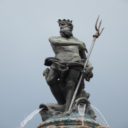

In [ ]:
# function to generate captions
def generate_caption(image):
    # Carica un'immagine da un URL


    # feature extractor
    encoded_input = feature_extractor(images=image, return_tensors="pt", max_length = 10).to(device)

    # model
    output_ids = model_capt.generate(**encoded_input,max_length = 30)

    # Decoding
    caption = tokenizer_capt.decode(output_ids[0], skip_special_tokens=True)
    return caption



example

Generated Caption: a statue of a man riding a horse  
while the word and its context are:  ['neptune', 'neptune statue']


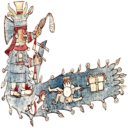



Generated Caption: a statue of a man standing on top of a lush green field  
while the word and its context are:  ['neptune', 'neptune statue']


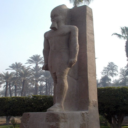



Generated Caption: a model of a ship with a wooden roof  
while the word and its context are:  ['neptune', 'neptune statue']


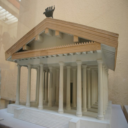



Generated Caption: a statue of a man with a bow on top of it  
while the word and its context are:  ['neptune', 'neptune statue']


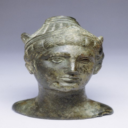



Generated Caption: a painting of a woman in a dress and a man in a suit  
while the word and its context are:  ['neptune', 'neptune statue']


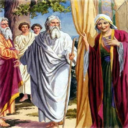



Generated Caption: a blue and white photo of a blue and white frisbee  
while the word and its context are:  ['neptune', 'neptune statue']


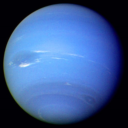



Generated Caption: a statue of a man holding a sword in front of a statue of a bird  
while the word and its context are:  ['neptune', 'neptune statue']


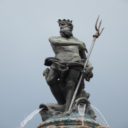



Generated Caption: a cat laying on a tree stump  
while the word and its context are:  ['neptune', 'neptune statue']


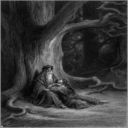



Generated Caption: a statue of a man sitting on a chair  
while the word and its context are:  ['neptune', 'neptune statue']


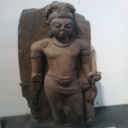



Generated Caption: a boy holding a stick in the air  
while the word and its context are:  ['neptune', 'neptune statue']


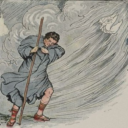





best image is:


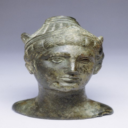

with the caption:  a statue of a man with a bow on top of it 

gold is


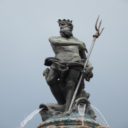

In [ ]:
max_similarity = -1
best_image = None
best_caption = None
elem = test_en_dataset.__getitem__(5)



for can in elem['list candidates']:

  if can.mode != 'RGB':   ## needs all the pictures to have te same format
    can = can.convert('RGB')
  # caption generation
  caption = generate_caption(can)

  # sentence embeddings
  embeddings = model_sen.encode([caption, elem['w2']])

  embeddings_tensor = torch.tensor(embeddings)

  # similarity
  cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


  # chose the highest similarity
  if cos_sim > max_similarity:
      max_similarity = cos_sim
      best_image = can
      best_caption = caption

  print("Generated Caption:", caption,'\nwhile the word and its context are: ', elem['words'])
  display(can)
  print('\n')


print('\n\nbest image is:')
display(best_image)
print('with the caption: ',best_caption)
print('\ngold is')
display(elem['label'][0])

## English

In [ ]:
tot_en = test_en_dataset.__len__()
correct_en = 0


for i in range(test_en_dataset.__len__()):
  elem = test_en_dataset.__getitem__(i)
  gold = elem['label'][0]
  max_similarity = -1
  best_image = None
  best_caption = None
  all_captions = []
  for can in elem['list candidates']:
    if can.mode != 'RGB':     ## need all the pictures to have the same format
      can = can.convert('RGB')
    # caption generation
    caption = generate_caption(can)
    all_captions.append(caption)

    # sentence embeddings
    embeddings = model_sen.encode([caption, elem['w2']])

    embeddings_tensor = torch.tensor(embeddings)

    # similarity
    cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


    # chose the highest similarity
    if cos_sim > max_similarity:
        max_similarity = cos_sim
        best_image = can
        best_caption = caption

  print(elem['words'],all_captions,best_caption)
  if best_image == gold:
    print('correct\n')
    correct_en += 1
  else:

    print('NOT CORRECT\n')
  # print(predicted_image,gold, predicted_image == gold)

['goal', 'football goal'] ['a field with a fence and a field with a fence ', 'a man wearing a blue and black mask ', 'a man in a blue shirt holding a soccer ball ', 'a woman is holding a tennis racket in her hand ', 'a man in a suit and tie ', 'a man kicking a soccer ball on a field ', 'a baseball team is sitting together ', 'a stadium with a large number of fans ', 'a soccer field with a green field and a green fence ', 'a sign that says "no smoking" '] a man kicking a soccer ball on a field 
NOT CORRECT

['mustard', 'mustard seed'] ['a small piece of food is sitting on a table ', 'a garden of vegetables and fruits ', 'a yellow and white flower in a field ', 'a wooden object with a black and white background ', 'a yellow bird sitting on a branch in the sun ', 'a single flower in a single flower pot ', 'a field with a building and a fire hydrant ', 'a spoon is sitting on a bowl of food ', 'a man riding a horse on a track ', 'a small bird is standing in a plant '] a garden of vegetables

In [ ]:
acc_en = correct_en/tot_en
acc_en

0.2678185745140389

## Italian

In [ ]:

tot_it = test_it_dataset.__len__()
correct_it = 0


for i in range(test_it_dataset.__len__()):
  item = test_it_dataset.__getitem__(i)
  texts = item['words']
  ### Translation ###

  tokenized_texts = tokenizer_translation_it(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_it.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato


  translated_tokens = translated_tokens.cpu()


  translated_text = [tokenizer_translation_it.decode(t, skip_special_tokens=True) for t in translated_tokens]



  ##################

  #### image captioning  ######

  gold = elem['label'][0]
  max_similarity = -1
  best_image = None
  best_caption = None
  all_captions = []
  for can in elem['list candidates']:
    if can.mode != 'RGB':     ## need all the pictures to have the same format
      can = can.convert('RGB')
    # caption generation
    caption = generate_caption(can)
    all_captions.append(caption)

    # sentence embeddings
    embeddings = model_sen.encode([caption, translated_text[1]])

    embeddings_tensor = torch.tensor(embeddings)

    # similarity
    cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


    # chose the highest similarity
    if cos_sim > max_similarity:
        max_similarity = cos_sim
        best_image = can
        best_caption = caption

  print(translated_text,all_captions,best_caption)
  if best_image == gold:
    print('correct\n')
    correct_it += 1
  else:

    print('NOT CORRECT\n')



['rubber', 'rubber for detaching'] ['a large blue and white object in the air ', 'a candle is lit up in a dark room ', 'a field full of flowers and a truck with a bunch of them ', 'a small blue and white flower in a blue and white purse ', 'a view from a plane of a mountain range ', 'a field with a bunch of flowers in it ', 'a piece of paper with a flower in it ', 'a small piece of paper with a flower inside ', 'a crowd of people watching a baseball game ', 'a rock with a reflection of a sun on it '] a rock with a reflection of a sun on it 
NOT CORRECT

['donkey', 'Ass card game'] ['a large blue and white object in the air ', 'a candle is lit up in a dark room ', 'a field full of flowers and a truck with a bunch of them ', 'a small blue and white flower in a blue and white purse ', 'a view from a plane of a mountain range ', 'a field with a bunch of flowers in it ', 'a piece of paper with a flower in it ', 'a small piece of paper with a flower inside ', 'a crowd of people watching a ba

In [ ]:
acc_it = correct_it/tot_it
acc_it

0.03934426229508197

## Farsi

In [ ]:

tot_fa = test_fa_dataset.__len__()
correct_fa = 0


for i in range(test_fa_dataset.__len__()):
  item = test_fa_dataset.__getitem__(i)
  texts = item['words']

  ###   translation   ####

  tokenized_texts = tokenizer_translation_fa(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  translated_tokens = model_translation_fa.generate(**tokenized_texts,
                                                 no_repeat_ngram_size=2)  ### no_repeat_ngram aiuta a prevenire la ripetizione di n-grams nel testo generato

  # move to cpu for decoding
  translated_tokens = translated_tokens.cpu()

  # decoding
  translated_text = [tokenizer_translation_fa.decode(t, skip_special_tokens=True) for t in translated_tokens]

  #################################

  #### image captioning  ######

  gold = elem['label'][0]
  max_similarity = -1
  best_image = None
  best_caption = None
  all_captions = []
  for can in elem['list candidates']:
    if can.mode != 'RGB':     ## need all the pictures to have the same format
      can = can.convert('RGB')
    # caption generation
    caption = generate_caption(can)
    all_captions.append(caption)

    # sentence embeddings
    embeddings = model_sen.encode([caption, translated_text[1]])

    embeddings_tensor = torch.tensor(embeddings)

    # similarity
    cos_sim = F.cosine_similarity(embeddings_tensor[0].unsqueeze(0), embeddings_tensor[1].unsqueeze(0))


    # chose the highest similarity
    if cos_sim > max_similarity:
        max_similarity = cos_sim
        best_image = can
        best_caption = caption

  print(translated_text,all_captions,best_caption)
  if best_image == gold:
    print('correct\n')
    correct_fa += 1
  else:

    print('NOT CORRECT\n')



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['rice', 'rice metal'] ['a large blue and white object in the air ', 'a candle is lit up in a dark room ', 'a field full of flowers and a truck with a bunch of them ', 'a small blue and white flower in a blue and white purse ', 'a view from a plane of a mountain range ', 'a field with a bunch of flowers in it ', 'a piece of paper with a flower in it ', 'a small piece of paper with a flower inside ', 'a crowd of people watching a baseball game ', 'a rock with a reflection of a sun on it '] a piece of paper with a flower in it 
NOT CORRECT

['- Meal.', 'A wind swallow.'] ['a large blue and white object in the air ', 'a candle is lit up in a dark room ', 'a field full of flowers and a truck with a bunch of them ', 'a small blue and white flower in a blue and white purse ', 'a view from a plane of a mountain range ', 'a field with a bunch of flowers in it ', 'a piece of paper with a flower in it ', 'a small piece of paper with a flower inside ', 'a crowd of people watching a baseball game 

In [ ]:
acc_fa = correct_fa/tot_fa
acc_fa

0.025

## total accuracy

In [ ]:
correct_tot = correct_en + correct_it + correct_fa
tot_tot = tot_en + tot_it + tot_fa
acc_tot = correct_tot/tot_tot
acc_tot

0.14566115702479338

In [ ]:
acc_en = correct_en/tot_en
acc_it = correct_it/tot_it
acc_fa = correct_fa/tot_fa
acc_en, acc_it, acc_fa

(0.2678185745140389, 0.03934426229508197, 0.025)

# Prediction files

In [ ]:
en_path = '/content/drive/MyDrive/Colab Notebooks Eren/hotnlp hw3/en.test.preds.txt'
it_path = '/content/drive/MyDrive/Colab Notebooks Eren/hotnlp hw3/it.test.preds.txt'
fa_path = '/content/drive/MyDrive/Colab Notebooks Eren/hotnlp hw3/fa.test.preds.txt'

In [ ]:
len(eng_pred), len(it_pred), len(fa_pred)

(463, 305, 200)

In [ ]:
# english
with open(en_path, "w") as file:
    for elem in eng_pred:
        file.write(f"{elem}\n")
file.close()

In [ ]:
# english
with open(it_path, "w") as file:
    for elem in it_pred:
        file.write(f"{elem}\n")
file.close()

In [ ]:
# english
with open(fa_path, "w") as file:
    for elem in fa_pred:
        file.write(f"{elem}\n")
file.close()